# Predicting NASDAQ indexes during the COVID-19 pandemic

## Data preprocessing

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression

In [2]:
DATA_DIR = './data/'
df_healthcare = pd.read_csv(DATA_DIR + 'IXHC.csv')
df_biotech = pd.read_csv(DATA_DIR + 'NBI.csv')
df_healthcare.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
257,2020-11-02,1023.380005,1100.969971,1003.500000,1087.619995,1087.619995,5046800
258,2020-11-09,1099.530029,1106.780029,1065.349976,1104.359985,1104.359985,6324500
259,2020-11-16,1111.469971,1111.489990,1078.869995,1091.459961,1091.459961,5446500
260,2020-11-23,1098.770020,1123.569946,1088.209961,1123.569946,1123.569946,3373000
261,2020-11-30,1132.060059,1135.439941,1116.579956,1135.010010,1135.010010,3571800


Our datasets include stock indexes from 2015/12/01 to 2020/12/01.

The names of columns are quite staightforward. Here we take **NASDAQ HealthCare** as an example:
+ Date: the first day of every week.
+ Open: the opening price in each week.
+ High: the highest price in each week.
+ Low: the lowest price in each week.
+ Close: the closing price in each week. To be more specific, closing prices on every Friday.

It's noted that **Date** is the first day of the weekly summary rather than the last day and that is the first issue. Besides, as we can observe, 2020-11-30 is the first day of the week so the last row of **NASDAQ HealthCare** dataframe is just the summary of prices for two days (2020-11-30 and 2020/12/01). It's safe to drop it.

In [3]:
df_healthcare['Date'] = pd.to_datetime(df_healthcare['Date'])
df_healthcare['Date'] = df_healthcare['Date'] + pd.Timedelta('6d')
df_healthcare.set_index('Date', inplace=True)
df_healthcare = df_healthcare[0:-1]

Now the **NASDAQ HealthCare** dateset is exactly what we want:

In [4]:
df_healthcare.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-11-01,1059.619995,1067.189941,1003.510010,1013.820007,1013.820007,4118400
2020-11-08,1023.380005,1100.969971,1003.500000,1087.619995,1087.619995,5046800
2020-11-15,1099.530029,1106.780029,1065.349976,1104.359985,1104.359985,6324500
2020-11-22,1111.469971,1111.489990,1078.869995,1091.459961,1091.459961,5446500
2020-11-29,1098.770020,1123.569946,1088.209961,1123.569946,1123.569946,3373000


We do the same process again for **NASDAQ Biotechnology** dataset:

In [5]:
df_biotech['Date'] = pd.to_datetime(df_biotech['Date'])
df_biotech['Date'] = df_biotech['Date'] + pd.Timedelta('6d')
df_biotech.set_index('Date', inplace=True)
df_biotech = df_biotech[0:-1]
df_biotech.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-11-01,4252.459961,4286.129883,4054.510010,4097.970215,4097.970215,1099300
2020-11-08,4125.450195,4469.339844,4033.139893,4355.970215,4355.970215,1197000
2020-11-15,4374.060059,4446.140137,4277.850098,4436.250000,4436.250000,1014200
2020-11-22,4466.890137,4466.890137,4318.939941,4364.149902,4364.149902,1243900
2020-11-29,4395.709961,4505.310059,4342.129883,4505.310059,4505.310059,595300


Here, We process Google Trends data (also from 2015/12/01 to 2020/12/01) about topic "Vaccine". The tail of the result dataframe matches the previous NASDAQ data.

In [6]:
df_trends = pd.read_csv(DATA_DIR + 'trends_data.csv')
df_trends.drop(labels=['Week'], axis=0, inplace=True)
df_trends.index = pd.to_datetime(df_trends.index)
df_trends.index.set_names('Date', inplace=True)
df_trends.rename(columns={'Category: All categories': 'Vaccine'}, inplace=True)
df_trends['Vaccine'] = df_trends['Vaccine'].apply(lambda x: int(x))

In [7]:
df_trends.tail()

,Vaccine
Date,
2020-11-01,27
2020-11-08,85
2020-11-15,84
2020-11-22,70
2020-11-29,100


After the individual processing, all three datesets share the same time index and can be merged perfectly. We first experiment with the closing prices of both stocks.

In [8]:
data = pd.DataFrame({'healthcare': df_healthcare['Close'],
                     'biotech': df_biotech['Close'],
                     'vaccine': df_trends['Vaccine']})
data.head(5)

,healthcare,biotech,vaccine
Date,,,
2015-12-06,743.700012,3470.639893,12
2015-12-13,718.440002,3347.600098,12
2015-12-20,735.000000,3449.010010,9
2015-12-27,757.659973,3555.060059,9
2016-01-03,752.390015,3540.439941,12


Let's take a look at the trends for both.

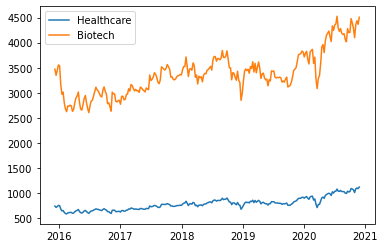

In [9]:
plt.plot(data['healthcare'], label='Healthcare')
plt.plot(data['biotech'], label='Biotech')
plt.legend()

It seems that **NASDAQ Healthcare** is much richer than the other one while facing wilder swings. 

To get a better grasp of how the both stocks fluctuate, let's compare another plot that uses standardized data.

In [10]:
def standardization(data):
    return (data-data.min())/(data.max()-data.min())

data['healthcare_std'] = standardization(data['healthcare'])
data['biotech_std'] = standardization(data['biotech'])

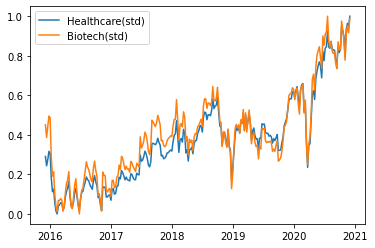

In [11]:
plt.plot(data['healthcare_std'], label='Healthcare(std)')
plt.plot(data['biotech_std'], label='Biotech(std)')
plt.legend()

Now the both trends over the past 5 years become more identical, and they seem to be in the same boat, rising and falling together.

In [12]:
import scipy.stats as stats
stats.pearsonr(data['healthcare'], data['biotech'])

(0.980973808774403, 2.1135374559961756e-186)

## Build the models

The baseline model can be concluded by the formula:

$$y_{t}^{health} \sim y_{t-1}^{health} + y_{t-4}^{health} + e$$

$y_t$: Closing price of NASDAQ Healthcare at time $t$.

$y_{t-4}$: Closing price of NASDAQ Healthcare at time $t-4$.

We now extract the features accordingly. Because there are no features available for the first 4 rows, so they need to be dropped.

In [13]:
data['healthcare.l1'] = data['healthcare'].shift(1)
data['biotech.l1'] = data['biotech'].shift(1)
data['healthcare.l4'] = data['healthcare'].shift(4)
data['biotech.l4'] = data['biotech'].shift(4)
data['vaccine.l1'] = data['vaccine'].shift(1)
data['vaccine.l4'] = data['vaccine'].shift(4)
data.dropna(inplace=True)
data.head()

,healthcare,biotech,vaccine,healthcare_std,biotech_std,healthcare.l1,biotech.l1,healthcare.l4,biotech.l4,vaccine.l1,vaccine.l4
Date,,,,,,,,,,,
2016-01-03,752.390015,3540.439941,12,0.306789,0.487119,757.659973,3555.060059,743.700012,3470.639893,9.0,12.0
2016-01-10,685.900024,3160.219971,12,0.182613,0.289124,752.390015,3540.439941,718.440002,3347.600098,12.0,12.0
2016-01-17,648.380005,2972.570068,12,0.112541,0.191408,685.900024,3160.219971,735.000000,3449.010010,12.0,9.0
2016-01-24,655.340027,3013.870117,13,0.125539,0.212914,648.380005,2972.570068,757.659973,3555.060059,12.0,9.0
2016-01-31,618.659973,2796.469971,13,0.057036,0.099706,655.340027,3013.870117,752.390015,3540.439941,13.0,12.0


In [14]:
X = data[['healthcare.l1', 'healthcare.l4']]
X = sm.add_constant(X)
y = data['healthcare']
model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:             healthcare   R-squared:                       0.955
Model:                            OLS   Adj. R-squared:                  0.955
Method:                 Least Squares   F-statistic:                     2688.
Date:                Thu, 17 Dec 2020   Prob (F-statistic):          1.27e-171
Time:                        06:49:11   Log-Likelihood:                -1202.1
No. Observations:                 257   AIC:                             2410.
Df Residuals:                     254   BIC:                             2421.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             5.0211     11.180      0.449

Old people always say that the stock market is unpredictable. We have learned the same lesson from the paper that we were asked to replicate. 

> As Nelson and Plosser (1982) and many subsequent authors have pointed out, it is very common for macroeconomic data to be represented as a random walk. For a random walk, the best univariate forecast for $y_t$ is simply $yt_1$. 

Let's see if we can gain slightly better $R^2$ by replacing $y_{t-4}^{health}$ with another feature.

In [15]:
X = data[['healthcare.l1', 'biotech.l1']]
X = sm.add_constant(X)
y = data['healthcare']
model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:             healthcare   R-squared:                       0.956
Model:                            OLS   Adj. R-squared:                  0.955
Method:                 Least Squares   F-statistic:                     2738.
Date:                Thu, 17 Dec 2020   Prob (F-statistic):          1.34e-172
Time:                        06:49:11   Log-Likelihood:                -1199.8
No. Observations:                 257   AIC:                             2406.
Df Residuals:                     254   BIC:                             2416.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const            38.2208     16.556      2.309

In [16]:
X = data[['healthcare.l1', 'vaccine.l1']]
X = sm.add_constant(X)
y = data['healthcare']
model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:             healthcare   R-squared:                       0.955
Model:                            OLS   Adj. R-squared:                  0.955
Method:                 Least Squares   F-statistic:                     2687.
Date:                Thu, 17 Dec 2020   Prob (F-statistic):          1.32e-171
Time:                        06:49:11   Log-Likelihood:                -1202.2
No. Observations:                 257   AIC:                             2410.
Df Residuals:                     254   BIC:                             2421.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const            15.2324     12.865      1.184

We have tried NASDAQ Biotechnology index, Google Trends on "Vaccine", and both of the new features. A surprising find is that, in the long run (in our case, 5 years), only NASDAQ Biotechnology index brings tiny improvement to the models with convincing p-value. However, Google Trends is likely to make no contribution to the models.

## A different direction: COVID-19 

It's time to scale our scope to this extraordinary year. One of the most significant event has changed the lives of countless millions of people. COVID-19 is still rife and must have caused unfathomable imfluence over the global economics. 

There is no doubt that the most iconic data about COVID-19 is the number of new cases for each day in each area. In order to explore the changes of stock market as far as possible, we utilize the COVID-19 data that comes from the European Union and focus on the new cases in USA.

In [17]:
df_cases = pd.read_csv(DATA_DIR + 'covid.csv')
df_us_covid = df_cases[df_cases['location'] == 'United States'] 
df_us_covid.set_index('date', inplace=True)
df_us_covid.fillna(0)
df_us_covid.index = pd.to_datetime(df_us_covid.index)
df_us_covid = df_us_covid[pd.Timestamp('2020-1-1'):pd.Timestamp('2020-12-1')]
df_us_covid.tail()

,iso_code,continent,location,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,total_cases_per_million,...,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index
date,,,,,,,,,,,,,,,,,,,,,
2020-11-27,USA,North America,United States,13088821.0,205514.0,166123.143,264858.0,1402.0,1477.286,39542.950,...,54225.446,1.2,151.089,10.79,19.1,24.6,NaN,2.77,78.86,0.924
2020-11-28,USA,North America,United States,13244701.0,155880.0,162949.286,266047.0,1189.0,1442.857,40013.882,...,54225.446,1.2,151.089,10.79,19.1,24.6,NaN,2.77,78.86,0.924
2020-11-29,USA,North America,United States,13383370.0,138669.0,162358.143,266873.0,826.0,1429.143,40432.819,...,54225.446,1.2,151.089,10.79,19.1,24.6,NaN,2.77,78.86,0.924
2020-11-30,USA,North America,United States,13541221.0,157851.0,160406.143,268045.0,1172.0,1466.143,40909.706,...,54225.446,1.2,151.089,10.79,19.1,24.6,NaN,2.77,78.86,0.924
2020-12-01,USA,North America,United States,13721858.0,180637.0,161498.857,270642.0,2597.0,1530.429,41455.433,...,54225.446,1.2,151.089,10.79,19.1,24.6,NaN,2.77,78.86,0.924


In [18]:
df_ns = pd.read_csv('./additional_data/^IXIC.csv')
df_ns['Date'] = pd.to_datetime(df_ns['Date'])
df_ns.set_index('Date', inplace=True)

df_ns = df_ns.reindex(pd.date_range(start=pd.Timestamp('2020-1-1'), end=pd.Timestamp('2020-12-1'), freq='1D'))
df_ns.iloc[0] = df_ns.iloc[1]
df_ns.interpolate(method='linear', inplace=True)    
df_ns.head()

,Open,High,Low,Close,Adj Close,Volume
2020-01-01,9039.459961,9093.429688,9010.889648,9092.190430,9092.190430,2.848370e+09
2020-01-02,9039.459961,9093.429688,9010.889648,9092.190430,9092.190430,2.848370e+09
2020-01-03,8976.429688,9065.759766,8976.429688,9020.769531,9020.769531,2.567400e+09
2020-01-04,8965.453125,9067.976563,8965.453125,9037.669596,9037.669596,2.640973e+09
2020-01-05,8954.476563,9070.193359,8954.476563,9054.569662,9054.569662,2.714547e+09


In [19]:
df_gt = pd.read_csv('./additional_data/google_trends.csv')
df_gt['date'] = pd.to_datetime(df_gt['date'])
df_gt.set_index('date', inplace=True)
df_gt.drop(['Unnamed: 0'], axis=1, inplace=True)
df_gt = df_gt[pd.Timestamp('2020-1-1'):pd.Timestamp('2020-12-1')]
df_gt.tail()

,vaccine_world,vaccine_US,unemployment_world,unemployment_US,trump_world,trump_US,lockdown_world,lockdown_US,loan_world,loan_US,italy_world,italy_US,election_world,election_US,covid_world,covid_US,china_world,china_US
date,,,,,,,,,,,,,,,,,,
2020-11-27,36.0,42.0,17.36,14.422222,8.0,16.0,12.923077,2.516129,60.2250,33.354839,13.575758,12.579710,0.5,0.5,43.0,45.617647,27.0,24.5
2020-11-28,39.0,47.0,14.26,12.455556,7.0,14.0,12.000000,4.645161,55.6625,33.354839,15.515152,14.405797,0.5,1.0,44.0,48.529412,27.6,26.0
2020-11-29,41.0,49.0,26.04,27.533333,7.0,13.0,11.076923,4.064516,52.9250,31.225806,15.515152,14.000000,0.5,0.5,43.0,49.500000,27.6,25.5
2020-11-30,48.0,61.0,31.62,30.155556,6.0,12.0,14.769231,4.064516,70.2625,42.580645,14.303030,12.782609,0.5,0.5,47.0,55.323529,28.8,28.0
2020-12-01,50.0,68.0,27.90,24.911111,6.0,12.0,13.846154,3.870968,72.0875,46.838710,13.818182,12.782609,0.5,0.5,47.0,55.323529,29.4,31.5


In [20]:
data_2020 = df_gt.copy()
data_2020['close'] = df_ns['Close']
data_2020[['new_cases', 'new_deaths']] = df_us_covid[['new_cases', 'new_deaths']]
data_2020.fillna(0, inplace=True)

data_2020['close.l1'] = data_2020['close'].shift(3)
data_2020 = data_2020.dropna()
data_2020.head()

,vaccine_world,vaccine_US,unemployment_world,unemployment_US,trump_world,trump_US,lockdown_world,lockdown_US,loan_world,loan_US,...,election_world,election_US,covid_world,covid_US,china_world,china_US,close,new_cases,new_deaths,close.l1
date,,,,,,,,,,,,,,,,,,,,,
2020-01-04,0.0,0.0,6.0,2.0,10.369565,15.189873,0.5,0.5,63.0,37.0,...,0.294118,0.318182,0.477778,0.5,27.0,28.0,9037.669596,0.0,0.0,9092.190430
2020-01-05,0.0,0.0,8.0,5.0,10.369565,14.430380,0.5,0.5,61.0,33.0,...,0.411765,0.363636,0.477778,0.5,27.0,27.0,9054.569662,0.0,0.0,9092.190430
2020-01-06,0.0,0.0,12.0,6.0,10.565217,14.810127,0.5,0.5,76.0,45.0,...,0.382353,0.409091,0.477778,0.5,27.0,26.0,9071.469727,0.0,0.0,9020.769531
2020-01-07,0.0,0.0,11.0,5.0,8.217391,12.151899,0.5,0.5,75.0,45.0,...,0.294118,0.318182,0.477778,0.5,27.0,27.0,9068.580078,0.0,0.0,9037.669596
2020-01-08,0.0,0.0,11.0,4.0,19.565217,26.582278,0.5,0.5,73.0,42.0,...,0.411765,0.272727,0.477778,0.5,28.0,28.0,9129.240234,0.0,0.0,9054.569662


After preprocessing, we get the relevant data for each week:

Now integrate and filter the data in 2020.

Another round of traing using data in 2020.

In [21]:
label = 'close'
base_features = ['close.l1']

base_X = data_2020[base_features]
base_X = sm.add_constant(base_X)
base_y = data_2020[label]
base_model = sm.OLS(base_y, base_X).fit()
print(base_model.summary())

                            OLS Regression Results                            
Dep. Variable:                  close   R-squared:                       0.967
Model:                            OLS   Adj. R-squared:                  0.967
Method:                 Least Squares   F-statistic:                     9608.
Date:                Thu, 17 Dec 2020   Prob (F-statistic):          1.32e-246
Time:                        06:49:11   Log-Likelihood:                -2300.7
No. Observations:                 333   AIC:                             4605.
Df Residuals:                     331   BIC:                             4613.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         83.7923    101.869      0.823      0.4

In [22]:
covid_features = ['close.l1', 'new_cases', 'new_deaths']

covid_X = data_2020[covid_features]
covid_X = sm.add_constant(covid_X)
covid_y = data_2020[label]
covid_model = sm.OLS(covid_y, covid_X).fit()
print(covid_model.summary())

                            OLS Regression Results                            
Dep. Variable:                  close   R-squared:                       0.969
Model:                            OLS   Adj. R-squared:                  0.968
Method:                 Least Squares   F-statistic:                     3399.
Date:                Thu, 17 Dec 2020   Prob (F-statistic):          3.77e-247
Time:                        06:49:11   Log-Likelihood:                -2290.2
No. Observations:                 333   AIC:                             4588.
Df Residuals:                     329   BIC:                             4604.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        211.3786    135.227      1.563      0.1

In [23]:
print(f'google trends            coef         p-value')
print(f'================================================')
for feature in data_2020.columns[0:len(df_gt.columns)]:
    features = ['close.l1', feature]
    X = data_2020[features]
    X = sm.add_constant(X)
    y = data_2020[label]
    model = sm.OLS(y, X).fit()
    
    print(f'{feature:20}   {model.params[feature]:10f}  {model.pvalues[feature]:10f}')

google trends            coef         p-value
vaccine_world           -0.428169    0.628653
vaccine_US              -1.767737    0.077053
unemployment_world       2.590138    0.000099
unemployment_US          2.462025    0.000065
trump_world              6.101422    0.000014
trump_US                 3.209738    0.004373
lockdown_world           1.475615    0.090801
lockdown_US             -3.057809    0.051918
loan_world               2.788800    0.071815
loan_US                  2.401897    0.094377
italy_world             -6.521413    0.000000
italy_US                -6.653386    0.000000
election_world           8.290986    0.000000
election_US              8.471869    0.000000
covid_world              1.458196    0.013850
covid_US                 1.063551    0.047630
china_world             -3.090117    0.037966
china_US                -6.371736    0.000008


In [24]:
start_date = pd.Timestamp('2020-2-1')
start_index = data_2020.index.tolist().index(start_date)

base = [-1.0] * start_index
cases = [-1.0] * start_index
deaths = [-1.0] * start_index

### Traing for out-sample forecasting. Here we use sklearn lib. 
out_base_model = LinearRegression()
out_cases_model = LinearRegression()
out_deaths_model = LinearRegression()

cases_features = ['close.l1', 'new_cases']
deaths_features = ['close.l1', 'new_deaths']

In [25]:
# As the rolling window become broader, more data can be used for trainig. 
for i in range(start_index, len(data_2020)):
    # Base model traing and predicting.
    out_base_model.fit(data_2020[:i][base_features], data_2020[:i][label])
    base_pred = out_base_model.predict([data_2020.iloc[i][base_features]])
    base.append(base_pred[0])
    
    out_cases_model.fit(data_2020[:i][cases_features], data_2020[:i][label])
    cases_pred = out_cases_model.predict([data_2020.iloc[i][cases_features]])
    cases.append(cases_pred[0])
    
    out_deaths_model.fit(data_2020[:i][deaths_features], data_2020[:i][label])
    deaths_pred = out_deaths_model.predict([data_2020.iloc[i][deaths_features]])
    deaths.append(deaths_pred[0])

In [26]:
data_2020['base'] = base
data_2020['cases'] = cases
data_2020['deaths'] = deaths

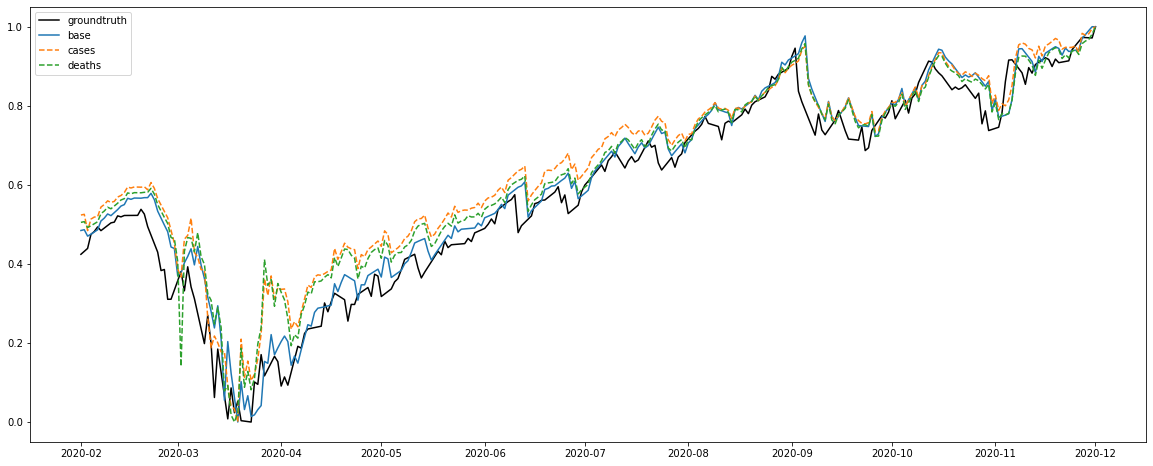

In [38]:
plt.figure(figsize=(20, 8))
plt.plot(standardization(data_2020[start_date:]['close']), 'k', label='groundtruth')
plt.plot(standardization(data_2020[start_date:]['base']), label='base')
plt.plot(standardization(data_2020[start_date:]['cases']), '--', label='cases')
plt.plot(standardization(data_2020[start_date:]['deaths']), '--', label='deaths')
# plt.plot(data_2020[start_date:]['close'], label='groundtruth')
# plt.plot(data_2020[start_date:]['base'], label='base')
# plt.plot(data_2020[start_date:]['cases'], '--', label='cases')
# plt.plot(data_2020[start_date:]['deaths'], '--', label='deaths')
plt.legend()

In [28]:
result = data_2020[start_date:]
base_mae = sum(abs(result['base'] - result[label]))/len(result[label])
cases_mae = sum(abs(result['cases'] - result[label]))/len(result[label])
deaths_mae = sum(abs(result['deaths'] - result[label]))/len(result[label])
print(base_mae)
print(cases_mae)
print(deaths_mae)

194.5728621739082
203.18239717694112
198.84960259975668


In [29]:
df_results = data_2020[['close', 'base', 'cases', 'deaths']].copy()

for feature in data_2020.columns[0:len(df_gt.columns)]:
    trends = [-1.0] * start_index
    trends_features = ['close.l1', feature]
    out_trends_model = LinearRegression()
    for i in range(start_index, len(data_2020)):
        # Trends model training and predicting.
        out_trends_model.fit(data_2020[:i][trends_features], data_2020[:i][label])
        trends_pred = out_trends_model.predict([data_2020.iloc[i][trends_features]])
        trends.append(trends_pred[0])
    df_results[feature] = trends

In [30]:
result = df_results[start_date:]
print(f'feature                MAE')
print('=================================')
for i in result.columns:
    mae = sum(abs(result[i] - result[label]))/len(result[label])
    print(f'{i:20} {mae:10f}')

feature                MAE
close                  0.000000
base                 194.572862
cases                203.182397
deaths               198.849603
vaccine_world        203.015785
vaccine_US           208.421115
unemployment_world   187.290349
unemployment_US      189.690996
trump_world          195.365284
trump_US             197.655514
lockdown_world       196.494893
lockdown_US          204.799808
loan_world           190.896669
loan_US              191.947459
italy_world          194.855408
italy_US             195.452797
election_world       195.497875
election_US          191.589265
covid_world          190.410567
covid_US             195.911872
china_world          194.512617
china_US             193.104107


In [31]:
# df_gov = pd.read_csv(DATA_DIR + 'OxCGRT_latest.csv')
# df_gov_us = df_gov.loc[df_gov['CountryName'] == 'United States']
# df_gov_us['RegionName'].unique()
# data_gov = df_gov_us[df_gov_us['RegionName'] == 'New York']
# data_gov.set_index('Date', inplace=True)
# data_gov.index = pd.to_datetime(data_gov.index, format="%Y%m%d")
# data_gov = data_gov[:pd.Timestamp('2020-12-1')]
# new_feature = 'GovernmentResponseIndexForDisplay'

# data_2020['gov'] = data_gov[new_feature]
# gov_X = data_2020[['close.l1', 'gov']]
# gov_X = sm.add_constant(gov_X)
# gov_y = data_2020['close']
# gov_model = sm.OLS(gov_y, gov_X).fit()
# print(gov_model.summary())

# stats.pearsonr(data_2020['gov'], data_2020['new_cases'])

In [32]:
turning_points = [[pd.Timestamp('2020-02-10'), pd.Timestamp('2020-02-25')],
                  [pd.Timestamp('2020-03-10'), pd.Timestamp('2020-03-30')],
                  [pd.Timestamp('2020-08-20'), pd.Timestamp('2020-09-15')],
                  [pd.Timestamp('2020-10-10'), pd.Timestamp('2020-11-10')]]

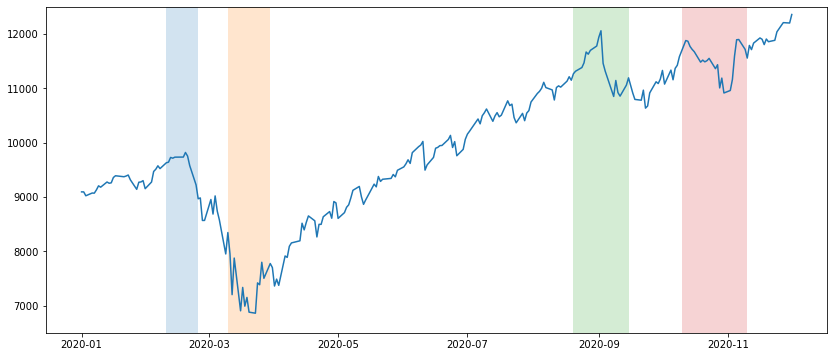

In [33]:
plt.figure(figsize=(14, 6))
y_min, y_max = 6500, 12500
plt.ylim([y_min, y_max])

plt.plot(df_ns['Close'])
for point_i in turning_points:
    plt.fill_betweenx([y_min, y_max], point_i[0], point_i[1], alpha=0.2)

In [34]:
df_turnings = pd.DataFrame(df_gt.columns.to_list(), columns=['Features'])

base_turning_maes = []
cases_turning_maes = []
deaths_turning_maes = []
for i in range(len(turning_points)):
    data_period = df_results[turning_points[i][0]:turning_points[i][1]]
    mae = sum(abs(data_period['base'] - data_period[label]))/len(data_period)
    base_turning_maes.append(mae)
    mae = sum(abs(data_period['cases'] - data_period[label]))/len(data_period)
    cases_turning_maes.append(mae)
    mae = sum(abs(data_period['deaths'] - data_period[label]))/len(data_period)
    deaths_turning_maes.append(mae)
    
print(base_turning_maes)
print(cases_turning_maes)
print(deaths_turning_maes)

[149.99839429604094, 350.947499222227, 212.50617437582966, 234.16643493198677]
[151.04907539905525, 526.4995564600518, 217.51033475132257, 260.94589268539494]
[149.99839429604094, 427.8498838305735, 202.05602515302868, 234.0823729725529]


In [35]:
for i in range(len(turning_points)):
    data_period = df_results[turning_points[i][0]:turning_points[i][1]]
    mae_col = f'Period_{i+1}'
    improvement_col = f'{mae_col}_ratio'
    maes = []
    for trend in df_turnings['Features']:
        mae = sum(abs(data_period[trend] - data_period[label]))/len(data_period)
        maes.append(mae)
    df_turnings[mae_col] = maes
    df_turnings[improvement_col] = -(df_turnings[mae_col] - base_turning_maes[i])/base_turning_maes[i]

In [36]:
df_turnings

,Features,Period_1,Period_1_ratio,Period_2,Period_2_ratio,Period_3,Period_3_ratio,Period_4,Period_4_ratio
0,vaccine_world,136.603232,0.089302,327.080856,0.068006,212.475172,0.000146,232.048730,0.009044
1,vaccine_US,138.951524,0.073647,260.293045,0.258313,211.486673,0.004798,222.006778,0.051927
2,unemployment_world,139.690232,0.068722,398.810842,-0.136383,198.909733,0.063981,237.540704,-0.014410
3,unemployment_US,151.118304,-0.007466,419.968671,-0.196671,200.219179,0.057819,238.492772,-0.018475
4,trump_world,152.579923,-0.017210,356.672949,-0.016314,210.520919,0.009342,218.792625,0.065653
5,trump_US,148.909992,0.007256,366.442223,-0.044151,212.078672,0.002012,231.427436,0.011697
6,lockdown_world,157.409227,-0.049406,464.515122,-0.323603,203.382170,0.042935,248.027809,-0.059195
7,lockdown_US,156.114279,-0.040773,454.419739,-0.294837,224.442990,-0.056172,226.696230,0.031901
8,loan_world,146.818981,0.021196,339.913341,0.031441,214.894862,-0.011241,229.473750,0.020040
9,loan_US,149.572427,0.002840,349.454121,0.004255,214.061486,-0.007319,236.354107,-0.009342


<BarContainer object of 18 artists>

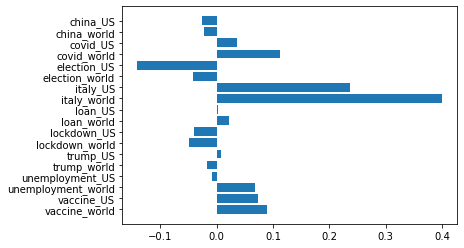

In [46]:
plt.barh(y=df_turnings['Features'], width=df_turnings['Period_1_ratio'])

<BarContainer object of 18 artists>

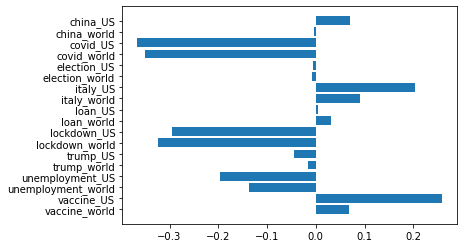

In [47]:
plt.barh(y=df_turnings['Features'], width=df_turnings['Period_2_ratio'])

<BarContainer object of 18 artists>

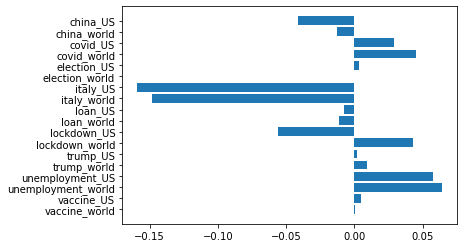

In [48]:
plt.barh(y=df_turnings['Features'], width=df_turnings['Period_3_ratio'])

<BarContainer object of 18 artists>

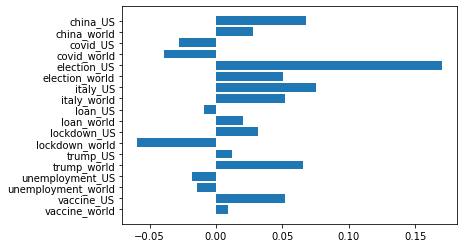

In [49]:
plt.barh(y=df_turnings['Features'], width=df_turnings['Period_4_ratio'])

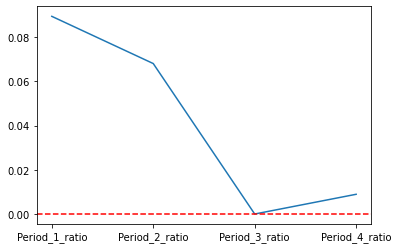

In [63]:
# improvement_cols = ['Period_1_ratio', 'Period_2_ratio', 'Period_3_ratio', 'Period_4_ratio']
# plt.plot(df_turnings[improvement_cols].iloc[0])
# plt.axhline(0, xmin=improvement_cols[0], xmax=improvement_cols[-1], color='red', ls='--')